In [ ]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
from constants import region_to_channel_dict, regions

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#Import Braindecode Model EEG Conformer
from braindecode.models import EEGConformer

### Brain-Region Channels 14 + 20 definitions etc. 

In [18]:
brain_regions_chans = ['Left Frontal', 'Left Frontal', 'Left Frontal', 'Left Central', 'Left Temporal', 'Left Parietal', 'Occipital', 'Occipital', 'Right Parietal', 
 'Right Temporal', 'Right Central', 'Right Frontal', 'Right Frontal', 'Right Frontal']

len(brain_regions_chans)

14

In [31]:
neuro_headset_channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
# These channels are equivalent to the neuro headset channels but for 'our' headset (There is code to generate these in notebook 18) 
eeg_14_channels = ['AF7', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF8']

#No Channels from Prefrontal, Frontal, Central or Parietal - I could add channels from these regions 2 per region = 20 channels
#Reasoning: To maintain symmetry between the left and right side of the brain and ensure all regions are represented in the channels:
#I will add one channel from Prefrontal 'Fpz', One channel from Frontal 'Fz', Two channels from Central 'FCz' & 'Cz' , One channel from Parietal 'Pz'
#And one channel from Occiptal 'Oz'
# Channels to add
channels_to_add = [ 'Fpz', 'Fz', 'FCz', 'Cz', 'Pz', 'Oz']

eeg_20_channels = eeg_14_channels + channels_to_add

len(eeg_20_channels)

#I want to re-order eeg_20_channels according to Brain Region order in region_to_channel_dict
eeg_20_channels_ordered = []
for value in region_to_channel_dict.values():
    eeg_20_channels_ordered += [channel for channel in eeg_20_channels if channel in value]

print(eeg_20_channels_ordered)

#Check to see that changing the ordering of the channels didn't negatively effect anything
print( sorted(eeg_20_channels) == sorted(eeg_20_channels_ordered) )

print(eeg_20_channels_ordered)

['Fpz', 'Fz', 'AF7', 'F7', 'F3', 'F4', 'F8', 'AF8', 'FCz', 'Cz', 'FC5', 'FC6', 'T7', 'T8', 'Pz', 'P7', 'P8', 'O1', 'O2', 'Oz']
True
['Fpz', 'Fz', 'AF7', 'F7', 'F3', 'F4', 'F8', 'AF8', 'FCz', 'Cz', 'FC5', 'FC6', 'T7', 'T8', 'Pz', 'P7', 'P8', 'O1', 'O2', 'Oz']


#### Load and re-save dataframes for each data type

In [42]:
data_types = ['Wake', 'N1', 'N2', 'N3', 'REM']

for data_type in data_types:
    print(data_type)
    df_list = joblib.load(data_type + '_normalised_dataframes.pkl')
    
    df_list_new = [df[eeg_20_channels_ordered].copy() for df in df_list]
    joblib.dump(df_list_new, data_type + '_20_channel_normalised_dataframes.pkl')

Wake
N1
N2
N3
REM


In [46]:
0.35*1.3

0.45499999999999996

In [10]:
region_to_channel_dict

{'Prefrontal': ['Fp1', 'Fpz', 'Fp2'],
 'Frontal': ['F1', 'Fz', 'F2'],
 'Left Frontal': ['AF7', 'F7', 'F5', 'F3'],
 'Right Frontal': ['AF8', 'F8', 'F6', 'F4'],
 'Central': ['FCz', 'FC1', 'FC2', 'Cz', 'C1', 'C2', 'CP1', 'CP2'],
 'Left Central': ['FC5', 'FC3', 'C5', 'C3', 'CP5', 'CP3'],
 'Right Central': ['FC6', 'FC4', 'C6', 'C4', 'CP6', 'CP4'],
 'Left Temporal': ['TP7', 'T7', 'FT7', 'FT9'],
 'Right Temporal': ['TP8', 'T8', 'FT8', 'FT10'],
 'Parietal': ['P1', 'P2', 'Pz'],
 'Left Parietal': ['P3', 'P5', 'P7', 'PO7'],
 'Right Parietal': ['P4', 'P6', 'P8', 'PO8'],
 'Occipital': ['POz', 'O1', 'O2', 'Oz']}

In [11]:
print( sorted(regions) )

['Central', 'Frontal', 'Left Central', 'Left Frontal', 'Left Parietal', 'Left Temporal', 'Occipital', 'Parietal', 'Prefrontal', 'Right Central', 'Right Frontal', 'Right Parietal', 'Right Temporal']


In [7]:
# Sorted list
sorted_brain_chans = sorted(brain_regions_chans)
sorted_brain_chans

['Left Central',
 'Left Frontal',
 'Left Frontal',
 'Left Frontal',
 'Left Parietal',
 'Left Temporal',
 'Occipital',
 'Occipital',
 'Right Central',
 'Right Frontal',
 'Right Frontal',
 'Right Frontal',
 'Right Parietal',
 'Right Temporal']

#### Old code from notebook 25

N1
Remember to change n_splits back to 4
Commencing Training ...
1


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


0


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.09 GiB. GPU 

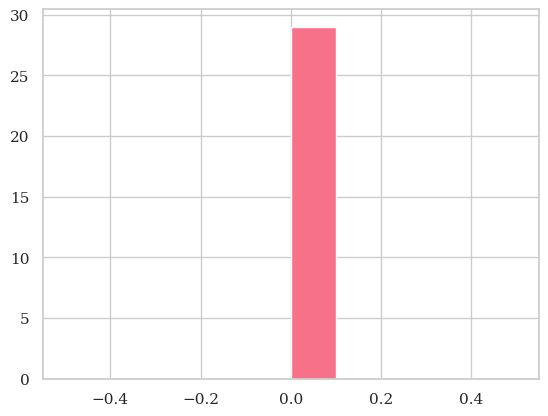

<Figure size 640x480 with 0 Axes>

<Figure size 2400x400 with 0 Axes>

In [3]:
t1 = time.time()

#1.Load the data ________________________________________________________________________________________


for data_type in [ 'N1']:
    for segment_length in [30720, 61440]:
    # for segment_length in [15360]:
    
        df_list = joblib.load(data_type + '_normalised_dataframes.pkl')
        
        print(data_type)    
        
        # 1. generate all path names and class list(s) etc. 
        folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
        paths = joblib.load(folder + data_type + '_paths.pkl') # keys : ['selected_paths', 's_class_list', 's_night_list', 's_sleep_type', 's_p_id']
        
        class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3} #Dictionary used to label the classes for reference
        y = np.array([class_label_dict[c_name] for c_name in paths['s_class_list'] ] )
        groups = paths['s_p_id']
        
        wake_dfs_binary = []
        y_binary = []
        groups_binary = []
        
        for df , class_label , group in zip(df_list, y, groups):
            if class_label in [0,1]:
                wake_dfs_binary.append(df)
                y_binary.append(class_label)
                groups_binary.append(group)
        
        y_binary = np.array(y_binary)
    
    #2. Generate 2 second segments of the data______________________________________________________________________ 
    
        #segment_length is user input and overlap is user input at the start of the script
        overlap = 0.5
        
        signal_slices = []
        y_slice_labels = []
        y_slice_groups = []
        
        for df, label, group in zip(wake_dfs_binary[:5], y_binary[:5], groups_binary[:5]):
            
            num_segments = int( np.floor(len(df)/segment_length) )
            new_specs = []
            
            for i in np.arange(0,num_segments, 1 - overlap):
                if i > num_segments - 1 :
                    # I don't want it to try to take an incomplete slice
                    # will be an incomplete slice causing errors downstream, needs to stop 
                    
                    break
                  
                start_index = int( np.floor(i*segment_length) )
                end_index = start_index + segment_length
                
                slice_df = df.iloc[start_index : end_index, :].copy()        
                signal_slices.append(slice_df)
                
                y_slice_labels.append(label)
                y_slice_groups.append(group)
                
        plt.hist(y_slice_labels)
    
    #3. Select the correct channels ______________________________________________________________________________
        
        channels_selected = eeg_14_channels # will later move this to the top of the notebook
        
        # signal_slices, y_slice_labels, y_slice_groups
        signal_slices_14_channels = [ df.loc[:, channels_selected].copy() for df in signal_slices ]
        
        # Make the slices an np array of the correct dimensions
        signal_slices_14_channels_np = [df.T.values for df in signal_slices_14_channels]
    
    #4. Create the network from the paper (REMOVED as I'm using EEG Conformer) 
    #The model is defined inside the training loop
    
    
    #5. Do Train Validation Splits
        # Train and Validation splits only ----> NO TEST
        # spectrogram_slices, y_slice_labels and y_slice_groups to work with
        train_val_dict = {}
        
        for value in ['train' , 'val']:
            train_val_dict[value] = {}
        
        X = np.stack(signal_slices_14_channels_np)
        y = np.array(y_slice_labels)
        groups = np.array( [int(group) for group in y_slice_groups] )
        
        gkf = GroupKFold(n_splits = 2)
        
        print('Remember to change n_splits back to 4')
        
        fold = 0
        
        for train_index, val_index   in gkf.split(X, y, groups*1):
            fold += 1
            
            X_train, y_train, groups_train  = X[train_index], y[train_index] , groups[train_index]
            X_val, y_val, groups_val =  X[val_index], y[val_index] , groups[val_index]   
            
            train_val_dict['train'][fold] = X_train, y_train, groups_train
            train_val_dict['val'][fold]   = X_val, y_val, groups_val
            
            total_len = len(X) 
            val_percent = 100*(len(X_val) / total_len)
            train_percent = 100*(len(X_train) / total_len)
            
            # Commented out the printing here
            # print('fold ' + str(fold) ) 
            # print( str(train_percent)[:3] + ' | '  + str(val_percent)[:3] + ' |' )
        
            # # testing that the splits are as expected
            # print( np.unique(groups_train) )
            # print( np.unique(groups_val) )
            
            # print('__________________________________________________________________________')
        
        #Output from this section of code is X_train, y_train, groups_train AND X_test, y_test, groups_test 
        import time
    
        start_time = time.time()
        
        seeds = [2]
        rows = len(seeds) # Make the figure the right size 
        
        fig = plt.figure()
        fig = plt.figure(figsize=(24,4*rows),dpi=100)
        
        # k is for subplots within the overall figure 
        
        k = 1
        print('Commencing Training ...')
        # Test out for 1 fold to start with
        
        for fold in [1,2,3,4]:
            print(fold)
            X_train, y_train, groups_train = train_val_dict['train'][fold]
            X_val, y_val, groups_val = train_val_dict['val'][fold]  
            
            # Creating train and test data loaders
            train_data = [ (torch.from_numpy(input_slice).float().view(num_channels,segment_length), val) for input_slice, val in zip(X_train, y_train) ] 
            train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
            
            val_data = [ (torch.from_numpy(input_slice).float().view(num_channels,segment_length), val) for input_slice, val in zip(X_val, y_val) ] 
            val_loader = DataLoader(val_data , batch_size=16, shuffle=False)
            
           
            
            
            
            # for seed in [2,5,15,50]:
            for seed in seeds:
                # set all seeds 
                random.seed(seed)
                np.random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed_all(seed) 
                
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                # print(device) - to check that device is actually cuda
                
                model = EEGConformer(
                    n_chans = num_channels,
                    n_outputs = 2 ,
                    n_times=segment_length,
                    att_depth=3,
                    att_heads=5,
                    final_fc_length = 'auto' 
                    )
                
                model.to(device)
                
                criterion = torch.nn.NLLLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )
    
                
                epochs = 35
                train_losses = []
                val_losses = []
                test_losses = []
                
                train_correct = []
                val_correct = []
                test_correct = []
                
                for i in range(epochs):
                    
                    trn_corr = 0
                    val_corr = 0
                    tst_corr = 0
                     
                    
                    trn_loss = 0
                    val_loss = 0
                    tst_loss = 0
                    
                    model.train()
                    # Run the training batches
                    for b, (X_train_batch, y_train_batch) in enumerate(train_loader):
                        # b+=1
                
                        #Move train data to the GPU
                        X_train_batch = X_train_batch.to(device)
                        y_train_batch = y_train_batch.to(device)
                        
                        # Apply the model
                        print(b)
                        y_pred = model(X_train_batch)  # we don't flatten X-train here
                        loss = criterion(y_pred, y_train_batch)
                 
                        # Tally the number of correct predictions
                        predicted = torch.argmax(torch.exp( y_pred.detach() ) ,  dim = 1 ) 
        
                        predicted = predicted.reshape(y_train_batch.shape)
                        
                        batch_corr = (predicted == y_train_batch).sum()
                        trn_corr += batch_corr
                        trn_loss += loss.item()
                        
                        # Update parameters
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                        
                    train_losses.append(trn_loss)
                    train_correct.append(trn_corr)
                
                    # Run the validation batches
                    # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
                    model.eval()
                    with torch.no_grad():
                        for b, (X_val_batch, y_val_batch) in enumerate(val_loader):
                            # b+=1
                            
                            #Move train data to the GPU
                            X_val_batch = X_val_batch.to(device)
                            y_val_batch = y_val_batch.to(device)
                
                            # Apply the model
                            y_val = model(X_val_batch)
                
                            # Tally the number of correct predictions
                            predicted = torch.argmax(y_val.detach(),  dim = 1 ) 
                            predicted = predicted.reshape(y_val_batch.shape)
                            
                            batch_corr = (predicted == y_val_batch).sum()
                            val_corr += batch_corr
                
                            loss = criterion(y_val, y_val_batch)
                            val_loss += loss.item()
                           
                    val_losses.append(val_loss)
                    val_correct.append(val_corr)
                
                    
                   
                
                # Plot the outcome from the loop
                
                ax = fig.add_subplot(rows,4,k)
                k+=1
                plt.title('fold ' + str(fold), fontsize = 10)
                plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
                plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epochs') 
                plt.grid()
            
            
            plt.tight_layout()
        
        
        plt.legend()   
        plt.tight_layout()
        
        #Add text at the bottom of the figure
        # fig.text(0.5, 0, 'This is a caption at the bottom of the figure | Model : ' + str(model) , va='bottom')
        fig.text(0.5, 0, f'\nDuration: {time.time() - start_time:.0f} seconds' , ha='center', va='bottom')
        
        plt.tight_layout(pad = 2.0)
    
        time_segment = str(segment_length/256)
        channels_num = str(num_channels)
        
        save_name = 'Results/Folder_3/' + data_type + '_' + 'Conformer_window_' + time_segment + '_secs_' + channels_num + '_channels' 
        plt.savefig(save_name +'.png')
            
        
        print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  
        print('Results Saved, on to next data type ...')
        
t2 = time.time()

t2 - t1

Wake 45 seconds took 260 seconds to run <br> 
Then it got an out of memory error --> OutOfMemoryError: CUDA out of memory. Tried to allocate 1.55 GiB. GPU 
